### <b> Read the mit-bih-normal-sinus-rhythm-database-1.0.0 </b>

In [1]:
import os
import torch
from scipy import signal
import heartpy.filtering
import numpy as np
import sys
import wfdb
from ecg_qc.ecg_qc import EcgQc
import pandas as pd
import logging
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:

database_path = "mit-bih-normal-sinus-rhythm-database-1.0.0/" # Path to the MIT-BIH Normal Sinus Rhythm Database
data_files = [database_path + file for file in os.listdir(database_path) if ".dat" in file]
save_path = '/save_path/' # Path to save the processed dataset


The frequency of the ECG signal is 128Hz and the window length is 5 seconds.

In [ ]:
fs = 128
win = 5
signal_quality = []
part = 1 # Patient number

Shift the window by one second and feed those windows to a ML model "ECG-QC" for predict how likely the window look like ECG signal so it's give a value between 0-1, and put that value in the signal_quality list.

In [ ]:
## Loop ecg.bin files
for participant, file in enumerate(data_files):
    counter = 0

    if participant==part:

        logging.critical("Participant: " + str(participant) + "/" + str(len(data_files)))

        data = wfdb.rdsamp(data_files[part][:-4])[0][:,0]
        ECG_SIGNAL = torch.Tensor(data)  # Final numpy array containing full days record

        # windows of 10 s
        pbar = tqdm(total=data.size/fs)
        for i in range(0, data.size, fs):
            min_limit = i
            max_limit = i + win * fs

            if (max_limit <= data.size):

                counter = counter + 1

                window_complete = ECG_SIGNAL[min_limit:max_limit]

                # Median Filter
                med = signal.medfilt(window_complete, 3)

                # Bandpass Filter
                filt = heartpy.filtering.filter_signal(med, [0.5, 30], fs, order=2,
                                                        filtertype='bandpass')

                # Signal Quality
                signal_quality_now = []
                win_intra = 1
                for k in range(win_intra * fs, window_complete.shape[0] + 1, win_intra * fs):
                    min_limit = k - win_intra * fs
                    max_limit = k
                    window_complete_intra = filt[min_limit:max_limit]
                    ecg_qc = EcgQc(model_file='xgb_9s.joblib', sampling_frequency=fs, normalized=False)
                    signal_quality_now.append(ecg_qc.get_signal_quality(window_complete_intra))

                signal_quality.append(np.mean(signal_quality_now))
                pbar.update(1)
np.save(f'signal_quality_{part+1}.npy', np.array(signal_quality))

CRITICAL:root:Participant: 1/18
  0%|          | 34/90000.0 [00:07<4:14:31,  5.89it/s]

KeyboardInterrupt: 

In [5]:
# Load signal_quality from a file named 'signal_quality_2.npy'
signal_quality_2_path = os.path.join(f'signal_quality_{part+1}.npy')
signal_quality = np.load(signal_quality_2_path)
print(signal_quality)

[1.  1.  1.  ... 0.4 0.6 0.6]


Mark as true ECG signal, not a arteffect that which windows values greater than 0.6.

In [6]:
is_quality = signal_quality < 0.6
print(is_quality)

[False False False ...  True False False]


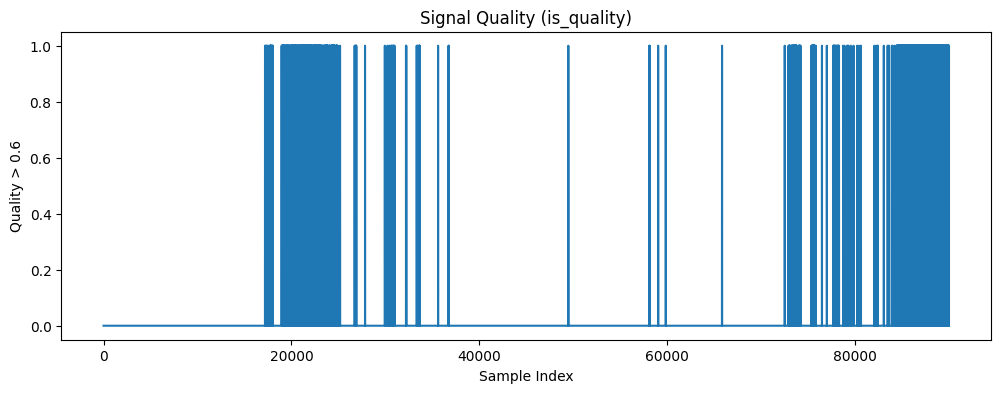

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(is_quality)
plt.title('Signal Quality (is_quality)')
plt.xlabel('Sample Index')
plt.ylabel('Quality > 0.6')
plt.show()

Find the arteffects intervals and put them in a arteffects_intervals list (This is only use for plotting purpose)

In [8]:
arteffects_intervals = []
min_limit = 0
max_limit = 0

for i,is_arteffect in enumerate(is_quality):

    if is_arteffect==True and (max_limit/fs) <=i:
        min_limit = i*fs
        max_limit = (i+5)*fs
        condition = True
        k = i
        while condition:
            k = k + 1
            if k<=len(is_quality)-1:
                if is_quality[k]==True:
                    max_limit = max_limit + fs
                else:
                    condition = False
            else:
                break
        arteffects_intervals.append((min_limit, max_limit))


In [10]:
data = wfdb.rdsamp(data_files[part][:-4])[0][:,0]
ECG_SIGNAL = torch.Tensor(wfdb.rdsamp(data_files[part][:-4])[0][:,0])

# Median Filter
ECG_SIGNAL = signal.medfilt(ECG_SIGNAL, 3)

# Bandpass Filter
ECG_SIGNAL = heartpy.filtering.filter_signal(ECG_SIGNAL, [0.5, 30], fs, order=2,
                                        filtertype='bandpass')

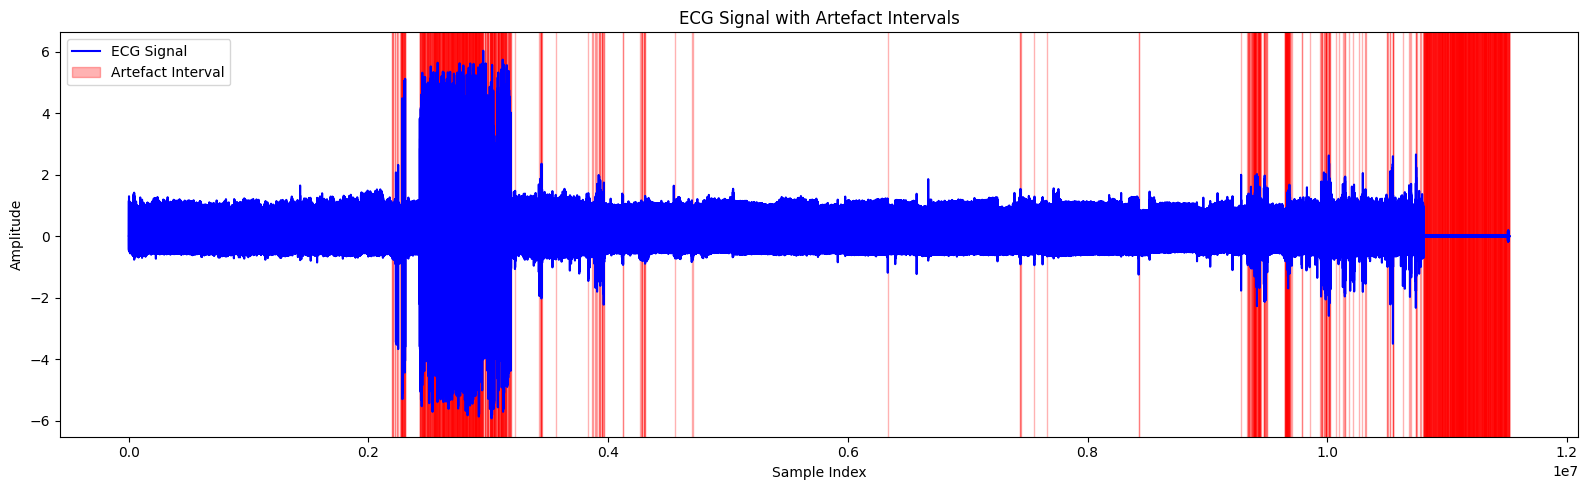

In [11]:
plt.figure(figsize=(16, 5))
plt.plot(ECG_SIGNAL, label='ECG Signal', color='blue')

for start, end in arteffects_intervals:
    plt.axvspan(start, end, color='red', alpha=0.3, label='Artefact Interval' if start == arteffects_intervals[0][0] else "")

plt.title('ECG Signal with Artefact Intervals')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

### <b>Read the mit-bih-arrhythmia-database-1.0.0 </b>

In [12]:
path = 'mit-bih-arrhythmia-database-1.0.0/' # Path to the MIT-BIH Arrhythmia Database
save_path = '/save_path/' # Path to save the processed dataset
valid_lead = ['MLII'] #, 'II', 'I', 'MLI', 'V5'

with open(os.path.join(path, 'RECORDS'), 'r') as fin:
    all_record_name = fin.read().strip().split('\n')

In [14]:
part_ar = 1 # Patient number
record_name = all_record_name[part_ar]

tmp_ann_res = wfdb.rdann(path + '/' + record_name, 'atr').__dict__
tmp_data_res = wfdb.rdsamp(path + '/' + record_name)

In [15]:
print(tmp_ann_res)

{'record_name': '101', 'extension': 'atr', 'sample': array([     7,     83,    396, ..., 649004, 649372, 649751], shape=(1874,)), 'symbol': ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '~', 'N', '|', 'N', 'N', 'N', 'N', '~', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

In [16]:
tmp_data_res

(array([[-0.345, -0.16 ],
        [-0.345, -0.16 ],
        [-0.345, -0.16 ],
        ...,
        [-0.295, -0.11 ],
        [-0.29 , -0.11 ],
        [ 0.   ,  0.   ]], shape=(650000, 2)),
 {'fs': 360,
  'sig_len': 650000,
  'n_sig': 2,
  'base_date': None,
  'base_time': None,
  'units': ['mV', 'mV'],
  'sig_name': ['MLII', 'V1'],
  'comments': ['75 F 1011 654 x1', 'Diapres']})

In [17]:
# Data
tmp_data = tmp_data_res[0][:, 0] # Use only MLII lead

In [18]:
# Positions
idx_list = list(tmp_ann_res['sample'])

In [19]:
label_beat_list = tmp_ann_res['symbol']
pd.DataFrame(tmp_ann_res['symbol'])[0].value_counts()

0
N    1860
~       4
|       4
A       3
Q       2
+       1
Name: count, dtype: int64